OpenAI/Gemini translation with or without dictionary

In [3]:
import openai
import google.generativeai as genai
from dotenv import load_dotenv
import os, re, time, json
import pandas as pd
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Set           # keep for type hints

# >>> NEW ─────────────────────────────────────────────────────────────────────
import spacy
from spacy.matcher import PhraseMatcher
# ─────────────────────────────────────────────────────────────────────────────

# --- Configuration ----------------------------------------------------------
load_dotenv()

# Choose which model provider to use
MODEL_PROVIDER = "openai"  # "openai" or "gemini"

# Initialize clients based on provider
if MODEL_PROVIDER == "openai":
    if "OPENAI_API_KEY" not in os.environ:
        raise ValueError("OPENAI_API_KEY not found in .env file or environment variables.")
    import openai
    client = openai.OpenAI()
elif MODEL_PROVIDER == "gemini":
    import google.generativeai as genai
    api_key = os.getenv("GOOGLE_API_KEY")
    if not api_key:
        raise ValueError("GOOGLE_API_KEY not found in .env file. Please add it.")
    genai.configure(api_key=api_key)
else:
    raise ValueError(f"Unknown model provider: {MODEL_PROVIDER}")

ENABLE_DICTIONARY = True
DICTIONARY_PATH   = "en_es_dictionary.txt"


# ── Utility ­­­functions ­­­(unchanged) --------------------------------------
def read_instruction_file(file_path: str) -> str:
    """Reads the system-prompt file (returns empty string on failure)."""
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read().strip()
    except FileNotFoundError:
        print(f"Warning: prompt file not found at {file_path}. Using empty prompt.")
        return ""
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

def load_en_es_dictionary(file_path: str) -> Dict[str, List[str]]:
    """
    Read a tab-separated EN–ES dictionary, preserving duplicate headwords.

    Returns
    -------
    dict[str, list[str]]
        {headword → [full_entry1, full_entry2, …]}
    """
    dictionary: Dict[str, List[str]] = defaultdict(list)
    
    try:
        with Path(file_path).open(encoding="utf-8") as f:
            for raw in f:
                if raw.startswith("#") or not raw.strip():
                    continue

                cols = raw.rstrip("\n").split("\t")
                if len(cols) < 2:
                    continue  # guard against malformed lines

                en_term, es_term = cols[0], cols[1]
                details = "\t".join(cols[2:])
                dictionary[en_term].append(f"{es_term} {details}".strip())
    except FileNotFoundError:
        print(f"Warning: Dictionary file not found at {file_path}. Proceeding without it.")
    except Exception as e:
        print(f"Error reading dictionary {file_path}: {e}")
    return dictionary

# >>> NEW — Missing function definition (used as fallback) ------------------
def find_relevant_dictionary_terms(text: str, dictionary: dict) -> dict:
    """Finds relevant terms from the dictionary in the given text."""
    relevant_terms = {}
    for term in dictionary:
        if re.search(r'\b' + re.escape(term) + r'\b', text, re.IGNORECASE):
            relevant_terms[term] = dictionary[term]
    return relevant_terms
# ─────────────────────────────────────────────────────────────────────────────

# >>> NEW ─────────────────────────────────────────────────────────────────────
class DictionaryMatcher:
    """
    Wraps a spaCy tokeniser + PhraseMatcher; keeps duplicates.
    """
    def __init__(
        self,
        dictionary: Dict[str, List[str]],
        # model: str = "en_core_web_sm",
        model: str = "en_core_web_trf",  # transformer-based model for better accuracy
        pos_focus: Set[str] = {"NOUN", "ADJ"},
    ) -> None:
        self.dictionary = dictionary
        self.nlp  = spacy.load(model, disable=["ner", "parser"])
        self.posF = pos_focus

        single, multi = set(), set()
        for h in dictionary:
            (multi if " " in h else single).add(h)

        # fast lemma map for single-word entries
        self.lemma2head = {h.lower(): h for h in single}

        # PhraseMatcher for multi-word entries
        self.phraser = PhraseMatcher(self.nlp.vocab, attr="LOWER")
        for phrase in multi:
            self.phraser.add(phrase, [self.nlp.make_doc(phrase)])

    def find_terms(self, text: str) -> Dict[str, List[str]]:
        doc  = self.nlp(text)
        hits = {}

        # lemma-based single words
        for t in doc:
            if t.pos_ in self.posF:
                head = self.lemma2head.get(t.lemma_.lower())
                if head:
                    hits[head] = self.dictionary[head]

        # multi-word phrases
        for mid, s, e in self.phraser(doc):
            head = self.nlp.vocab.strings[mid]          # original headword
            span = doc[s:e].text.lower()
            if span == head.lower():
                hits[head] = self.dictionary[head]

        return hits
# ─────────────────────────────────────────────────────────────────────────────

def translate_text_batch_json(
    batch_dict: dict,
    system_prompt_content: str,
    dictionary_context: str,
    model_name: str = "gpt-4.1",
    temperature: float = 1,
    context_translations: list[str] | None = None,
    provider: str = "openai",
) -> dict:

    # Build the prompt --------------------------------------------------------
    context_block = ""
    if context_translations:
        context_block = (
            "## Previous Context\n\n"
            "**Previous translated lines** (do NOT modify these):\n\n"
            + "\n".join(f"- {line}" for line in context_translations) + "\n\n"
        )

    dictionary_context_block = ""
    if dictionary_context:
        dictionary_context_block = (
            "## Dictionary Context\n\n"
            "**Format**: English term → Spanish translation(s)\n"
            "**Note**: Multiple options are separated by ` | `\n\n"
            f"{dictionary_context}\n\n"
        )

    texts_json = json.dumps(batch_dict, indent=2, ensure_ascii=False)
    
    if provider == "openai":
        user_prompt = (
            "# Translation Task\n\n"
            "Please translate each value in the JSON object from English to Spanish "
            "following the rules in the system prompt. Return exactly one JSON object "
            "with identical keys and the translated Spanish text as values.\n\n"
            
            "## Translation Guidelines\n\n"
            "1. **Follow ALL rules** specified in the system prompt\n"
            "2. **Use dictionary entries** below for additional context and accuracy\n"
            "3. **Dictionary format**: English term → Spanish translation(s)\n"
            "4. **Multiple variants**: When Spanish variants are shown (separated by `|`), choose the most appropriate one for context\n"
            "5. **Priority**: Dictionary suggestions should complement, not override, system prompt rules\n\n"
            f"{dictionary_context_block}"
            "## Input JSON to Translate\n\n"
            "```json\n" + texts_json + "\n```\n\n"
            
            # "## Required Output Format\n\n"
            # "**Return a valid JSON object** with:\n"
            # "- Same keys as the input\n"
            # "- Spanish translations as values\n"
            # "- No other text, explanations, or formatting outside the JSON object\n\n"
            # "**Example output format:**\n"
            # "```json\n"
            # '{"0": "Spanish translation here", "1": "Another Spanish translation"}\n'
            # "```"
        )
    else:  # gemini
        user_prompt = (
            "Please translate each value in the JSON object from English to Spanish "
            "following the rules in the system prompt. Return exactly one JSON object "
            "with identical keys.\n\n"
            f"{context_block}"
            f"{dictionary_context_block}"
            "Input Texts:\n" + texts_json
        )

    try:
        if provider == "openai":
            # --- Call the OpenAI API ---
            response = client.chat.completions.create(
                model=model_name,
                response_format={"type": "json_object"},
                temperature=temperature,
                messages=[
                    {"role": "system", "content": system_prompt_content},
                    {"role": "user", "content": user_prompt}
                ]
            )
            
            print("user prompt:", user_prompt)
            response_content = response.choices[0].message.content
            return json.loads(response_content)
        
        elif provider == "gemini":
            # --- Call the Gemini API ---
            model = genai.GenerativeModel(
                model_name=model_name,
                system_instruction=system_prompt_content,
                generation_config={
                    "temperature": temperature,
                    "response_mime_type": "application/json",
                },
            )
            
            response = model.generate_content(user_prompt)
            return json.loads(response.text)
        
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from model response. Error: {e}")
        if 'response_content' in locals():
            print(f"Model response was:\n---\n{response_content}\n---")
        elif 'response' in locals():
            print(f"Model response was:\n---\n{response.text}\n---")
        return {}
    except Exception as e:
        if provider == "openai" and hasattr(e, '__class__') and 'openai' in str(e.__class__):
            print(f"An OpenAI API error occurred: {e}")
        else:
            print(f"An API error occurred: {e}")
        time.sleep(1)
        return {}

# >>> CHANGED  (added *matcher* arg and provider support) -------------------
def process_csv_with_llm(
    input_file: str,
    output_file: str,
    model_name: str,
    system_prompt_content: str,
    dictionary: dict | None,
    matcher: "DictionaryMatcher | None",      # ← new
    provider: str = "openai",                 # ← new
    batch_size: int = 50,
):
    """
    Reads a CSV, translates the 'Segment Text' column in batches,
    and writes a new CSV with 'Translated Text'.
    """
    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: input file not found: {input_file}")
        return

    if "Segment Text" not in df.columns:
        print("Error: 'Segment Text' column not found.")
        return

    df["Translated Text"] = pd.NA
    texts_series = df["Segment Text"].dropna()
    num_batches = (len(texts_series) + batch_size - 1) // batch_size
    previous_context_lines: list[str] = []

    for start in range(0, len(texts_series), batch_size):
        batch_series = texts_series[start:start + batch_size]
        batch_dict   = batch_series.to_dict()

        # >>> CHANGED — use spaCy matcher if present
        if matcher is not None:
            rel_terms = matcher.find_terms(" ".join(batch_series.astype(str)))
        elif dictionary:
            rel_terms = find_relevant_dictionary_terms(" ".join(batch_series.astype(str)),
                                                       dictionary)
        else:
            rel_terms = {}

        # Format dictionary context to show all variants more clearly
        dict_lines = []
        for k, v in rel_terms.items():
            if isinstance(v, list):
                # Show all variants for this term, cleaned up
                variants = " | ".join(entry.strip() for entry in v)
                dict_lines.append(f"• {k} → {variants}")
            else:
                dict_lines.append(f"• {k} → {v}")
        dictionary_context = "\n".join(dict_lines)

        print(f"Batch {start // batch_size + 1}/{num_batches} "
              f"(rows {batch_series.index.min()}–{batch_series.index.max()})")
        # show what was found
        # print("  term_hits ➜", list(rel_terms) or "∅")

        translated = translate_text_batch_json(
            batch_dict=batch_dict,
            system_prompt_content=system_prompt_content,
            dictionary_context=dictionary_context,
            model_name=model_name,
            temperature=0,
            context_translations=previous_context_lines,
            provider=provider,                    # ← pass provider
        )

        if translated:
            for idx, es in translated.items():
                df.loc[int(idx), "Translated Text"] = es
            ordered_ids = list(batch_series.index)
            ordered_es  = [translated[str(i)] for i in ordered_ids if str(i) in translated]
            previous_context_lines = ordered_es[: max(1, len(ordered_es)//2)]

    df.to_csv(output_file, index=False, encoding="utf-8-sig")
    print(f"\n✅  Translation finished → {output_file}")


# ── Main --------------------------------------------------------------------
if __name__ == "__main__":
    input_csv_path  = r"D:\SOKM\11 Identity 2 SoKM 2024 - 2025\11 Identity 2 SoKM 2024 - 2025_transcript_english_SE_reduced_converted.csv"
    system_prompt_file = "system_prompt_translate_v2.0.txt"
    # Model configuration - change these to switch between providers
    if MODEL_PROVIDER == "openai":
        model_name = "gpt-4.1"
    elif MODEL_PROVIDER == "gemini":
        model_name = "gemini-2.5-pro"
    
    system_prompt_content = read_instruction_file(system_prompt_file)

    en_es_dictionary = (load_en_es_dictionary(DICTIONARY_PATH)
                        if ENABLE_DICTIONARY else {})

    # >>> NEW — build matcher once
    matcher = (DictionaryMatcher(en_es_dictionary)
               if ENABLE_DICTIONARY else None)

    model_tag = re.sub(r"[^A-Za-z0-9]", "_", model_name)
    # system_prompt_content_tag contains only the version number, not the full content 
    # Eg: system_prompt_translate_v1.1 should lead to system_prompt_content_tag = "v1.1"
    # This is useful for generating output file names.
    system_prompt_content_tag = re.search(r"v\d+\.\d+", system_prompt_file).group(0)
    dictionary_tag = "d_" if ENABLE_DICTIONARY else ""
    provider_tag = f"{MODEL_PROVIDER}_"
    output_csv_path = input_csv_path.replace(
        ".csv", f"_translated_{dictionary_tag}{provider_tag}{model_tag}_p{system_prompt_content_tag}.csv"
    )
    
    process_csv_with_llm(
        input_file=input_csv_path,
        output_file=output_csv_path,
        model_name=model_name,
        system_prompt_content=system_prompt_content,
        dictionary=en_es_dictionary,
        matcher=matcher,                 # ← pass matcher
        provider=MODEL_PROVIDER,         # ← pass provider
        batch_size=30,
    )

Batch 1/2 (rows 0–29)
user prompt: # Translation Task

Please translate each value in the JSON object from English to Spanish following the rules in the system prompt. Return exactly one JSON object with identical keys and the translated Spanish text as values.

## Translation Guidelines

1. **Follow ALL rules** specified in the system prompt
2. **Use dictionary entries** below for additional context and accuracy
3. **Dictionary format**: English term → Spanish translation(s)
4. **Multiple variants**: When Spanish variants are shown (separated by `|`), choose the most appropriate one for context
5. **Priority**: Dictionary suggestions should complement, not override, system prompt rules

## Dictionary Context

**Format**: English term → Spanish translation(s)
**Note**: Multiple options are separated by ` | `

• week → semana {f} noun
• thought → pensamiento {m} noun
• many → mucho adj adv
• incomplete → incompleto adj
• picture → cuadro {m} noun	[art] | imagen {f} noun | película {f} n

PermissionError: [Errno 13] Permission denied: 'D:\\SOKM\\11 Identity 2 SoKM 2024 - 2025\\11 Identity 2 SoKM 2024 - 2025_transcript_english_SE_reduced_converted_translated_d_openai_gpt_4_1_pv2.0.csv'

Evaluating translations

c:\Users\robin\anaconda3\envs\text-processing\lib\site-packages\torchmetrics\utilities\imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loading COMET … 

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Encoder model frozen.
c:\Users\robin\anaconda3\envs\text-processing\lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


done.
Evaluating d_gpt_4_1_pv1.2 …


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 41/41 [00:08<00:00,  5.00it/s]


Evaluating d_openai_gpt_4_1_pv1.2_u1 …


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 41/41 [00:07<00:00,  5.54it/s]


Evaluating gpt_4_1_pv2.0 …


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 41/41 [00:07<00:00,  5.34it/s]


All models evaluated.

Row‑level metrics → D:\SOKM\Testing\01 Introduction SoKM 2024 - 2025 transcript_translation_Proofread_row_metrics.csv
Model summary     → D:\SOKM\Testing\01 Introduction SoKM 2024 - 2025 transcript_translation_Proofread_summary_metrics.csv



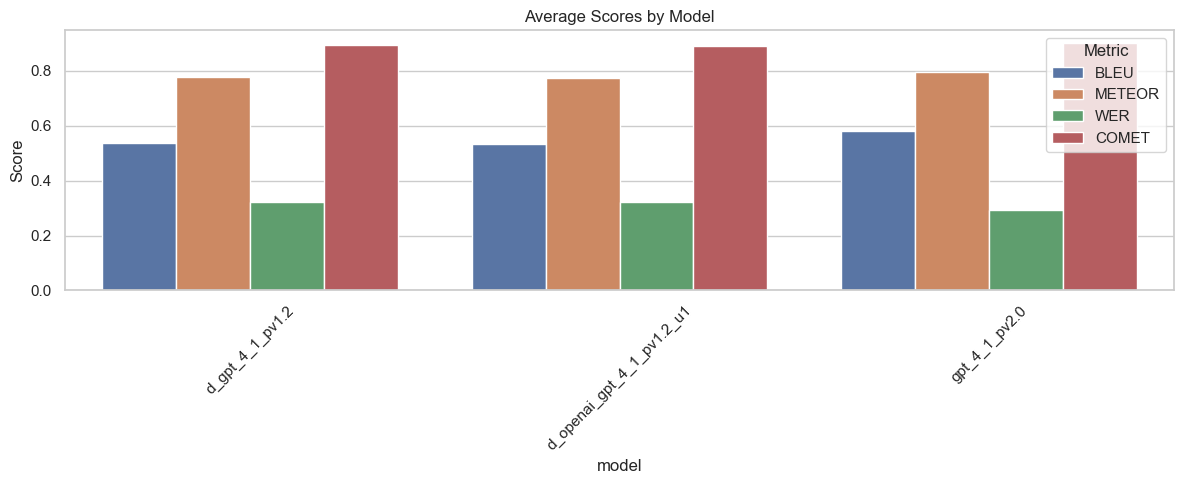

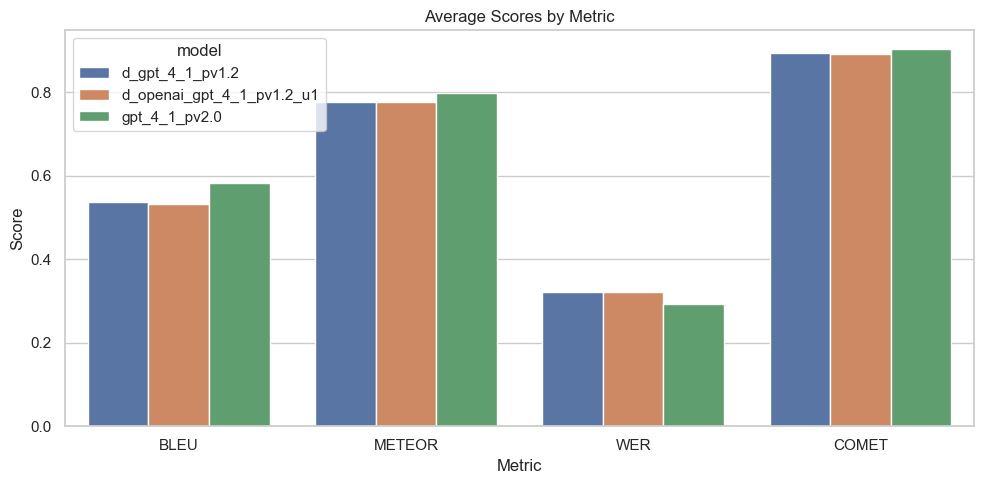

In [2]:
import glob
import os
import re
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import jiwer
from jiwer import wer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from comet import download_model, load_from_checkpoint

"""Translation‑evaluation utility

Compares multiple machine‑translation (MT) outputs against a native‑speaker
reference and plots average BLEU, METEOR, WER, and COMET scores.

Assumptions
-----------
* **Reference file** contains the canonical translation plus the English source
  text:
    D:\SOKM\01 Introduction SoKM 2024 - 2025 transcript_translation_Proofread.csv
  ├─ Segment Text              (English source)
  └─ Translation_nativespeaker (reference)

* **MT outputs** live in *Testing* with naming pattern
    4k_audio_english_fixed_testtiny_translated_<model>.csv
  └─ Translated Text           (model hypothesis)
  They do **not** repeat the Segment Text column; we align by row order.

The script discovers all MT files automatically, computes sentence‑level scores
in one pass per model, saves both row‑wise and model‑wise CSVs next to the
reference, and draws two grouped bar plots.
"""

# ───────────────────────────── paths & columns ──────────────────────────────
# REFERENCE_CSV = (
#     r"D:\SOKM\Testing\01 Introduction SoKM 2024 - 2025 "
#     r"transcript_translation_Proofread.csv"
# )
# MT_PATTERN = (
#     r"D:\SOKM\Testing\01 Introduction SoKM 2024 - 2025 "
#     r"4k_audio_english_fixed_translated_*.csv"
# )
REFERENCE_CSV = (
    r"D:\SOKM\Testing\01 Introduction SoKM 2024 - 2025 "
    r"transcript_translation_Proofread.csv"
)
MT_PATTERN = (
    r"D:\SOKM\Testing\01 Introduction SoKM 2024 - 2025 "
    r"4k_audio_english_fixed_translated_*.csv"
)
SRC_COL = "Segment Text"
REF_COL = "Translation_nativespeaker"
HYP_COL = "Translated Text"
ENC = "cp1252"

# ───────────────────────────── metric helpers ───────────────────────────────
_smooth = SmoothingFunction().method1

def bleu(r: str, h: str) -> float:
    return sentence_bleu([word_tokenize(r.lower())],
                         word_tokenize(h.lower()),
                         smoothing_function=_smooth)

def meteor(r: str, h: str) -> float:
    return meteor_score([word_tokenize(r.lower())],
                        word_tokenize(h.lower()))

def wer_acc(r: str, h: str) -> float:
    transforms = jiwer.Compose(
        [
            jiwer.ExpandCommonEnglishContractions(),
            jiwer.RemoveEmptyStrings(),
            jiwer.ToLowerCase(),
            jiwer.RemoveMultipleSpaces(),
            jiwer.Strip(),
            jiwer.RemovePunctuation(),
            jiwer.ReduceToListOfListOfWords(),
        ]
    )

    wer = jiwer.wer(
                r,
                h,
                reference_transform=transforms,
                hypothesis_transform=transforms,
                )
    
    return wer  # accuracy style (higher = better)

# ───────────────────────────── load reference ───────────────────────────────
ref_df = pd.read_csv(REFERENCE_CSV, encoding=ENC, usecols=[SRC_COL, REF_COL])
source_texts = ref_df[SRC_COL].tolist()
references   = ref_df[REF_COL].tolist()
num_segments = len(ref_df)

# ───────────────────────────── load COMET once ─────────────────────────────
print("Loading COMET …", end=" ")
ckpt = download_model("Unbabel/wmt22-comet-da")
comet = load_from_checkpoint(ckpt)
USE_GPU = int(torch.cuda.is_available())
print("done.")

# ───────────────────────────── process each MT file ─────────────────────────
summary_rows, row_metrics_frames = [], []

for mt_csv in glob.glob(MT_PATTERN):
    model_name = re.search(r"translated_(.*?).csv", Path(mt_csv).name).group(1)
    print(f"Evaluating {model_name} …")

    hyp_df = pd.read_csv(mt_csv, encoding=ENC, usecols=[HYP_COL])
    hypotheses = hyp_df[HYP_COL].tolist()

    if len(hypotheses) != num_segments:
        raise ValueError(
            f"Row mismatch: {model_name} has {len(hypotheses)} rows, "
            f"reference has {num_segments}.")
    
    # sentence‑level metrics
    bleu_scores, meteor_scores, wer_scores, comet_batch = [], [], [], []

    for src, ref, hyp in zip(source_texts, references, hypotheses):
        bleu_scores.append(bleu(ref, hyp))
        meteor_scores.append(meteor(ref, hyp))
        wer_scores.append(wer_acc(ref, hyp))
        comet_batch.append({"src": src, "mt": hyp, "ref": ref})

    comet_scores = comet.predict(comet_batch, batch_size=16, gpus=USE_GPU).scores

    # collect row‑level output
    frame = pd.DataFrame({
        SRC_COL: source_texts,
        REF_COL: references,
        HYP_COL: hypotheses,
        "BLEU": bleu_scores,
        "METEOR": meteor_scores,
        "WER": wer_scores,
        "COMET": comet_scores,
        "model": model_name,
    })
    row_metrics_frames.append(frame)

    # model averages
    summary_rows.append({
        "model": model_name,
        "BLEU": sum(bleu_scores)   / num_segments,
        "METEOR": sum(meteor_scores) / num_segments,
        "WER": sum(wer_scores)    / num_segments,
        "COMET": sum(comet_scores)  / num_segments,
    })

print("All models evaluated.\n")

# ───────────────────────────── save CSVs ────────────────────────────────────
base = Path(REFERENCE_CSV).with_suffix("")
row_csv     = f"{base}_row_metrics.csv"
summary_csv = f"{base}_summary_metrics.csv"

pd.concat(row_metrics_frames, ignore_index=True).to_csv(row_csv, index=False,encoding=ENC)
pd.DataFrame(summary_rows).to_csv(summary_csv, index=False, encoding=ENC)
print(f"Row‑level metrics → {row_csv}\nModel summary     → {summary_csv}\n")

# ───────────────────────────── plots ────────────────────────────────────────
summary_long = pd.DataFrame(summary_rows).melt("model", var_name="Metric", value_name="Score")

sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=summary_long, x="model", y="Score", hue="Metric")
ax.set_title("Average Scores by Model")
plt.xticks(rotation=45)
plt.tight_layout()

plt.figure(figsize=(10, 5))
ax2 = sns.barplot(data=summary_long, x="Metric", y="Score", hue="model")
ax2.set_title("Average Scores by Metric")
plt.tight_layout()

plt.show()
